In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-twodim-nonlinear)=
# Nonlinear elliptic PDEs

Many nonlinear elliptic PDEs include references to the Laplacian operator.

(example-mems2dmodel)=
::::{proof:example}
Recall the micromechanical deflector modeled in a disk by {eq}`mems`. A fully two-dimensional equivalent is (see {cite}`peleskoEffectSmallaspectratio2006`)
  
:::{math}
:label: mems2d
\Delta u - \frac{\lambda}{(u+1)^2} = 0.
:::

This may be posed on any region, with $u=0$ specified everywhere on the boundary.
::::

More generally, we want to solve the nonlinear equation

:::{math}
:label: nonlinpdepde
\phi(x,y,u,u_x,u_y,u_{xx},u_{yy}) = 0
:::

in the interior of a rectangle $R$, subject to the Dirichlet condition

:::{math}
:label: nonlinpdebc
u(x,y) = g(x,y)
:::

on the boundary of $R$.

## Implementation

```{index} quasi-Newton method
```

In order to solve for as few unknowns as possible, we use a Chebyshev discretization of the domain. The core idea is to formulate collocation equations at the grid points based on discrete approximations of {eq}`nonlinpdepde` and {eq}`nonlinpdebc`. If the PDE is nonlinear, then these equations are also nonlinear and are to be solved by a quasi-Newton iteration. {numref}`Function {number} <function-elliptic>` is our implementation. 

(function-elliptic)=
````{proof:function} elliptic
**Newton's method to solve an elliptic PDE**
```{code-block} julia1
:lineno-start: 1
"""
    elliptic(ϕ,g,m,xspan,n,yspan)

Solve the elliptic PDE `ϕ`(x,y,u,u_x,u_xx,u_y,u_yy)=0 on the 
rectangle `xspan` x `yspan`, subject to `g`(x,y)=0 on the boundary. 
Uses `m`+1 points in x by `n`+1 points in y in a Chebyshev 
discretization.

Returns vectors defining the grid and a matrix of grid solution values.
"""
function elliptic(ϕ,g,m,xspan,n,yspan)
    # Discretize the domain.
    x,Dx,Dxx = diffcheb(m,xspan)
    y,Dy,Dyy = diffcheb(n,yspan)
    X = [ x for x in x, y in y ]
    Y = [ y for x in x, y in y ]
    unvec = u -> reshape(u,m+1,n+1)
    
    # Identify boundary locations and evaluate the boundary condition.
    isboundary = trues(m+1,n+1)
    isboundary[2:m,2:n] .= false
    idx = vec(isboundary)
    gb = g.(X[idx],Y[idx])

    # Evaluate the discretized PDE and its Jacobian, with all the
    # boundary condition modifications applied.
    function residual(u)
        U = unvec(u)
        R = ϕ(X,Y,U,Dx*U,Dxx*U,U*Dy',U*Dyy')
        @. R[idx] = u[idx] - gb
        return vec(R)
    end

    # Solve the equation.
    u = levenberg(residual,vec(zeros(size(X))))[end]
    U = unvec(u)

    return function (ξ,η)
		v = [ chebinterp(x,u,ξ) for u in eachcol(U) ]
		return chebinterp(y,v,η)
    end

end
```
````

```{index} Julia; indexing arrays
```

::::{admonition} About the code
:class: dropdown
The boundary values are accessed using Boolean indexing. One advantage of this style, though it is not exploited here, is that the complementary points can also be accessed via the Boolean NOT operator `!`. Note that any indexing array either has to be the same size as the object of the indexing, or a vector with the same number of elements. In this function, for example, `X[idx]`, `X[isboundary]`, and `u[idx]` would all be valid, but `u[isboundary]` would not be.
::::

{numref}`Function {number} <function-elliptic>` first defines the discretization and then computes all the values of $g$ at the boundary nodes. It uses {numref}`Function {number} <function-levenberg>` as the nonlinear solver, and it translates back and forth between vector and grid shapes for the unknowns. After the discrete PDE is collocated at the grid points, the boundary terms are replaced by the boundary residual.

Lines 38–41, which produce the value returned by {numref}`Function {number} <function-elliptic>`, provide a function that evaluates the numerical solution anywhere in the domain, as is explained next.

## Off-grid evaluation

A Chebyshev grid is clustered close to the boundary of the domain, and the grid values may be accurate even for modest grid sizes. As a result, simple piecewise interpolation to evaluate off the grid, as is done by plotting routines, may be unacceptably inaccurate. Instead, we should use the global polynomial interpolation that is foundational to the Chebyshev spectral method.

Let $\mathbf{U}$ be a matrix of solution values on the Chebyshev grid, defining a function $u(x,y)$, and let $(\xi,\eta)$ be a point where we want to evaluate $u(x,y)$. Column $\mathbf{u}_j$ of the grid matrix represents values spanning all the $x_i$ while $y$ is fixed at $y_j$. Therefore, we can define an interpolating polynomial $p_j(x)$ based on the values in $\mathbf{u}_j$. 

Now let $v_j = p_j(\xi)$ for $j=1,\ldots,n$. The vector $\mathbf{v}$ is a discretization of $u(\xi,y)$ at the Chebyshev nodes in $y$. It defines an interpolating polynomial $q(y)$, and finally we have $u(\xi,\eta)=q(\eta)$. You can think of the total process as reducing one dimension at a time through the action of evaluating a polynomial interpolant at a point.

The function returned by {numref}`Function {number} <function-elliptic>` performs interpolation as described above, using a helper function `chebinterp` (not shown). The helper performs the evaluation of a polynomial interpolant in one variable using a modified implementation of {numref}`Function {number} <function-polyinterp>` that exploits the barycentric weights for Chebyshev nodes given in {eq}`weightcheb`.[^grideval]  

[^grideval]: The interpolation algorithm in {numref}`Function {number} <function-elliptic>` is inefficient when $u$ is to be evaluated on a finer grid, as for plotting. A more careful version could re-use the same values $v_j = p_j(\xi)$ for multiple values of $\eta$.  

(demo-nonlinear-mems)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We solve the PDE

$$
\Delta u - \frac{\lambda}{(u+1)^2} = 0
$$

on the rectangle $[0,2.5] \times [0,1]$, with a zero Dirichlet condition on the boundary.

All we need to define are $\phi$ from {eq}`nonlinpdepde` for the PDE, and a trivial zero function for the boundary condition.

In [2]:
λ = 1.5
ϕ = (X,Y,U,Ux,Uxx,Uy,Uyy) -> @. Uxx + Uyy - λ/(U+1)^2;
g = (x,y) -> 0; 

Here is the solution for $m=15$, $n=8$.

In [3]:
u = FNC.elliptic(ϕ,g,15,[0,2.5],8,[0,1]);

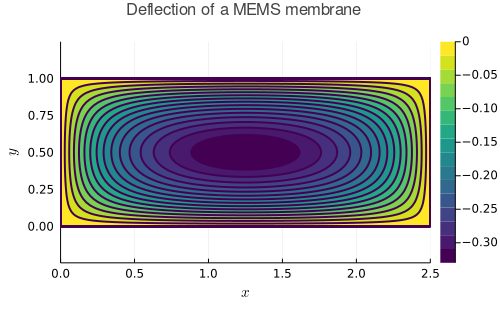

In [4]:
x = range(0,2.5,length=100)
y = range(0,1,length=50)
U = [u(x,y) for x in x, y in y]
contourf(x,y,U',color=:viridis,aspect_ratio=1,
    xlabel=L"x",ylabel=L"y",zlabel=L"u(x,y)",
    title="Deflection of a MEMS membrane",
    right_margin=3Plots.mm)        

In the absence of an exact solution, how can we be confident that the solution is accurate? First, the Levenberg iteration converged without issuing a warning, so we should feel confident that the discrete equations were solved. We can check the boundary values easily. For example,

In [5]:
x = range(0,2.5,length=100)
norm( [u(x,0) - g(x,0) for x in x], Inf )

3.491687516723461e-23

Assuming that we encoded the PDE correctly, the remaining source error is truncation from the discretization. We can estimate that by refining the grid a bit and seeing how much the numerical solution changes.

In [6]:
[ u(x,y) for x in 0.5:0.5:2, y in 0.25:0.25:0.75 ]

4×3 Matrix{Float64}:
 -0.174521  -0.236562  -0.174521
 -0.23255   -0.320498  -0.23255
 -0.23255   -0.320498  -0.23255
 -0.174521  -0.236562  -0.174521

In [7]:
u = FNC.elliptic(ϕ,g,25,[0,2.5],14,[0,1]);
[ u(x,y) for x in 0.5:0.5:2, y in 0.25:0.25:0.75 ]

4×3 Matrix{Float64}:
 -0.174516  -0.236554  -0.174516
 -0.23255   -0.320475  -0.23255
 -0.23255   -0.320475  -0.23255
 -0.174516  -0.236554  -0.174516

The original solution may be accurate to about four digits.

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


```{index} advection-diffusion equation
```
(demo-nonlinear-advdiff)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

The steady-state limit of an advection-diffusion equation is 

$$
1 - u_x - 2u_y + \epsilon \, \Delta u = 0.
$$

Here we solve it with a homogeneous Dirichlet condition on the square $[-1,1]^2$.

In [8]:
ϕ = (X,Y,U,Ux,Uxx,Uy,Uyy) -> @. 1 - Ux - 2Uy + 0.05*(Uxx + Uyy)
g = (x,y) -> 0
u = FNC.elliptic(ϕ,g,32,[-1,1],32,[-1,1]);

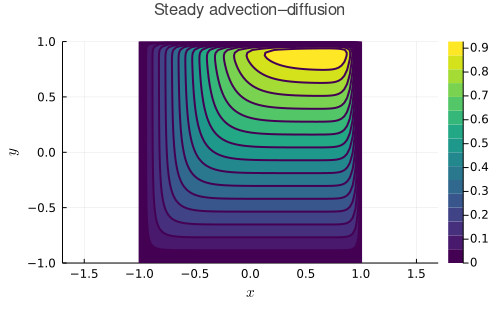

In [9]:
x = y = range(-1,1,length=80)
U = [u(x,y) for x in x, y in y]
contourf(x,y,U',color=:viridis,aspect_ratio=1,
     xlabel=L"x",ylabel=L"y",zlabel=L"u(x,y)",
     title="Steady advection–diffusion")

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


```{index} Allen–Cahn equation
```

(demo-nonlinear-allencahn)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

The stationary Allen–Cahn equation in two dimensions is 

$$
u(1-u^2)+\epsilon \, \Delta u = 0.
$$

The following defines the PDE and a nontrivial Dirichlet boundary condition for the square $[0,1]^2$.

In [10]:
ϕ = (X,Y,U,Ux,Uxx,Uy,Uyy) -> @. U*(1-U^2) + 0.05*(Uxx + Uyy)  
g = (x,y) -> tanh(5*(x+2y-1));

We solve the PDE and then plot the result.

In [11]:
u = FNC.elliptic(ϕ,g,36,[0,1],36,[0,1]);

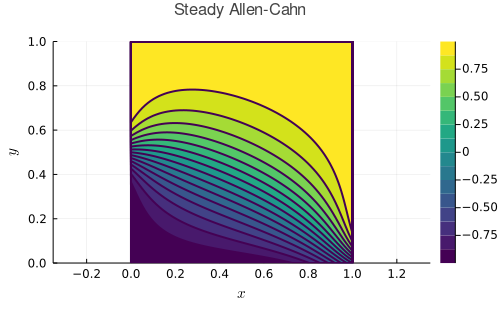

In [12]:
x = y = range(0,1,length=80)
U = [u(x,y) for x in x, y in y]
contourf( x,y,U',color=:viridis,aspect_ratio=1,
    xlabel=L"x",ylabel=L"y",zlabel=L"u(x,y)",title="Steady Allen-Cahn",
    right_margin=3Plots.mm )

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


## Exercises

1. ⌨ **(a)** Solve for the steady state of 
   
    $$
    u_t = - u_y - x - 2 + \epsilon ( u_{xx} + u_{yy} )
    $$

    for $\epsilon=1$ in $[-1,1]\times[-1,1]$, subject to a homogeneous Dirichlet boundary condition. Use $m=n=30$ points and plot the solution.

    **(b)** Repeat part (a) for $\epsilon=0.1$, which weakens the influence of diffusion relative to advection.

    ```{index} soap film
    ```
2. ⌨ A soap film stretched on a wire frame above the $(x,y)$ plane assumes a shape $u(x,y)$ of minimum area and is governed by
   
    \begin{align*}
      \operatorname{div} \, \left( \frac{\operatorname{grad} u}{\sqrt{1 + u_x^2 + u_y^2}} \right) &= 0 \text{ in region $R$},\\
      u(x,y) &= g(x,y) \text{ on the boundary of $R$}.
    \end{align*}
    
    Solve the equation on $[-1,1]^2$ with boundary value $u(x,y)=\tanh(y-2x)$, and make a surface plot of the result. (Hints: Don't try to rewrite the PDE. Instead, modify {numref}`Function {number} <function-elliptic>` so that `ϕ` is called with arguments `(U,Dx,Dy)`, and compute the PDE in the form given. Also, since convergence is difficult in this problem, use the boundary data over the whole domain as the initial value for `levenberg`.)

3. Modify {numref}`Function {number} <function-elliptic>` to solve {eq}`nonlinpdepde` on $[a,b] \times [c,d]$ with the mixed boundary conditions

    $$
    u = 0, \text{ if } x=a \text{ or } y = d, \qquad  \frac{\partial u}{\partial n} = 0, \text{ if } x=b \text{ or } y = c,
    $$

    where $\frac{\partial}{\partial n}$ is the derivative in the direction of the outward normal. Either condition can be used at a corner point. (Hint: Define index vectors for each side of the domain.) Apply your solver to the PDE $\Delta u + \sin(3\pi x) = 0$ on $[0,1]^2$, and make a contour plot of the solution. Why do the level curves intersect two of the sides only at right angles?